# Setup

In [51]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import ssm
from ssm.util import find_permutation
import pandas as pd
npr.seed(0)

In [67]:
root_dir = '/home/veithweilnhammer/Public/Git/Modes_2/Yuki/'
root_dir = 'C:/Users/Veith Weilnhammer/Github/Modes_2/Yuki/'

### what to do
save_data = True

## Initialize GLM-HMM

## Load and prepare inputs

In [17]:
### read and data 
df = pd.read_csv(root_dir + 'prepared_Data_HMM.csv')

In [18]:
### Set the parameters of the GLM-HMM
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2        # input dimensions
N_iters = 500

In [36]:
inpts = []
choices = []

for load_idx in participants:
    this_data = df.loc[df['ID'] == load_idx].copy()
        ## start with estimating the experiment as a whole
    num_sess = 1
    num_trials_per_sess = len(this_data)

    new_inpts = []
    new_choices = []

    new_inpts = np.ones((num_trials_per_sess, input_dim))

    ## get input format
    new_inpts[:, 0] = this_data['contrast'].copy()
    new_inpts[:, 1] = this_data['previous_response'].copy()
    #new_inpts[:, 2] = this_data['previous_contrast'].copy()
    #new_inpts[:, 2] = np.ones(this_data.shape[0])
    inpts.append(new_inpts)

    new_choices = this_data['response'].copy()
    new_choices = np.atleast_2d(new_choices).T
    choices.append(new_choices) 

## Fit at group-level in one-state GLM-HMM

In [ ]:
### fit one state GLM-HMM at group level

num_states = 1
n_iter = 100

transition_alpha = 1
prior_sigma = 10

iter_array = np.full([n_iter, 2], np.nan)
for idx in range(n_iter):
    
    one_state_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, 
                    observations="input_driven_obs", 
                    observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma), 
                    transitions="sticky", 
                    transition_kwargs=dict(alpha=transition_alpha, kappa=0))
    print(one_state_glmhmm.params)
    one_state_glmhmm.fit(choices, inputs=inpts, method="em", num_iters=N_iters, initialize = True, tolerance=10**-4, verbose = False)
    iter_array[idx,] = one_state_glmhmm.observations.params.reshape((1,2))


In [55]:
df_iter_array = pd.DataFrame(iter_array, columns = ['contrast', 'previous_response'])
if save_data:
    df_iter_array.to_csv(root_dir + 'HMM/one_level_HMM_params.csv', index = False) 

In [37]:
df_iter_array = pd.read_csv(root_dir + 'HMM/one_level_HMM_params.csv')
params_for_initalization = df_iter_array.mean().values
print(params_for_initalization)

[-1.04750461 -0.47686341]


# Fit multi-state GLM-HMMs at group-level and compare BIC

In [69]:
## compare models based on BIC
max_num_states =  2    # number of discrete states

N_iters = 500 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
# Make a GLM-HMM
prior_sigma = 10
transition_alpha = 1

BIC = []
for state_idx in range(max_num_states): 
    print(state_idx)
    compare_glmhmm = ssm.HMM(state_idx+1, obs_dim, input_dim, 
                    observations="input_driven_obs", 
                    observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma), 
                    transitions="sticky", 
                    transition_kwargs=dict(alpha=transition_alpha, kappa=0))

    
    _ = compare_glmhmm.fit(choices, inputs=inpts, method="em", num_iters=N_iters, initialize = True, tolerance=10**-4, verbose = False)
    n_total_params = np.concatenate(compare_glmhmm.observations.params).size + np.concatenate(compare_glmhmm.transitions.params).size
    
    # Flatten choices and inpts to calculate log likelihood correctly
    flattened_choices = np.concatenate(choices)
    flattened_inpts = np.concatenate(inpts)

    new_BIC = np.log(np.size(flattened_choices))*n_total_params - 2*compare_glmhmm.log_likelihood(choices, inputs=inpts)
    
    if save_data:
        pd.DataFrame(np.append(new_BIC, np.concatenate(compare_glmhmm.observations.params))).to_csv(root_dir + 'HMM/Full_model_outcome_states_' + str(state_idx + 1) + '.csv', index = False)

    BIC = np.append(BIC, new_BIC) 
    print(compare_glmhmm.observations.params)

df_BIC = pd.DataFrame({'BIC': BIC, 'num_states': np.arange(max_num_states) + 1})


if save_data:
    df_BIC.to_csv(root_dir + 'HMM/BIC_across_models.csv', index = False)


0
[[[-1.04734747 -0.47679658]]]
1
[[[-0.99947591 -1.41217484]]

 [[-1.19790288 -0.04353043]]]


array([-1117.02208506])

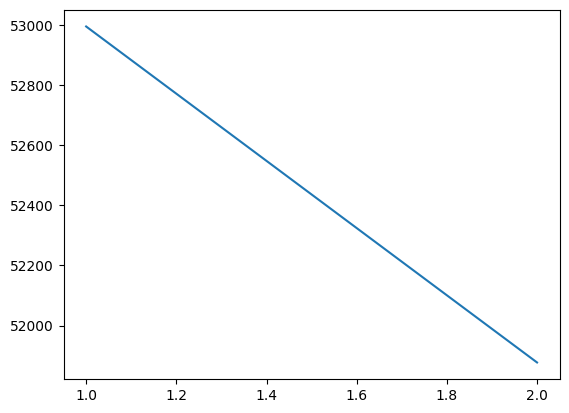

In [70]:
df_BIC = pd.read_csv(root_dir + 'HMM/BIC_across_models.csv')
plt.plot(df_BIC['num_states'], df_BIC['BIC'])
np.diff(df_BIC.BIC)

# Fit permuted multi-state GLM-HMMs at group-level and compare BIC

In [ ]:
# Permutation analysis
n_perm = 100
BIC_permuted = []

for perm_idx in range(n_perm):
    permuted_choices = []
    permuted_inpts = []
    
    for i in range(len(choices)):
        perm_indices = np.random.permutation(choices[i].shape[0])
        permuted_choices.append(choices[i][perm_indices])
        permuted_inpts.append(inpts[i][perm_indices])
    
    for state_idx in range(max_num_states):
        print(f"Permutation {perm_idx}, State {state_idx}")
        permuted_glmhmm = ssm.HMM(state_idx + 1, obs_dim, input_dim, 
                                  observations="input_driven_obs", 
                                  observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma), 
                                  transitions="sticky", 
                                  transition_kwargs=dict(alpha=transition_alpha, kappa=0))

        _ = permuted_glmhmm.fit(permuted_choices, inputs=permuted_inpts, method="em", num_iters=N_iters, initialize=True, tolerance=10**-4, verbose=False)

        n_total_params = np.concatenate(permuted_glmhmm.observations.params).size + np.concatenate(permuted_glmhmm.transitions.params).size

        # Compute log likelihood
        log_likelihood = permuted_glmhmm.log_likelihood(permuted_choices, inputs=permuted_inpts)

        # Compute BIC
        new_BIC = np.log(len(flattened_choices)) * n_total_params - 2 * log_likelihood
        BIC_permuted.append({'perm_idx': perm_idx, 'state_idx': state_idx + 1, 'BIC': new_BIC})

df_BIC_permuted = pd.DataFrame(BIC_permuted)
if save_data:
    df_BIC_permuted.to_csv(root_dir + 'HMM/BIC_permuted_across_models.csv', index=False)

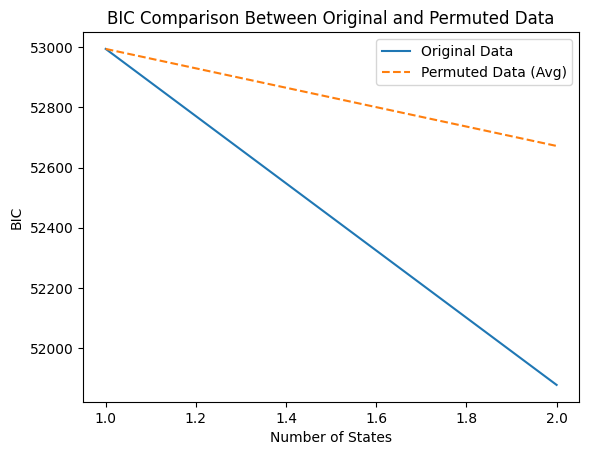

[-1117.01741079]


In [66]:
# Average BIC across permutations
df_BIC_permuted_avg = df_BIC_permuted.groupby('state_idx').agg({'BIC': 'mean'}).reset_index()

# Plotting
plt.plot(df_BIC['num_states'], df_BIC['BIC'], label='Original Data')
plt.plot(df_BIC_permuted_avg['state_idx'], df_BIC_permuted_avg['BIC'], label='Permuted Data (Avg)', linestyle='--')
plt.xlabel('Number of States')
plt.ylabel('BIC')
plt.legend()
plt.title('BIC Comparison Between Original and Permuted Data')
plt.show()

# Compute differences in BIC for original data
bic_diff = np.diff(df_BIC['BIC'])
print(bic_diff)

# Fit two-state GLM-HMMs 

In [ ]:
npr.seed(0)
# Set the parameters of the GLM-HMM
num_states =  2      # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2      # input dimensions

N_iters = 500 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
# Make a GLM-HMM

prior_sigma = 10
transition_alpha = 1

n_iter = 10
parameters_ext_int = np.full([n_iter, 8], np.nan)
for idx in range(n_iter):
    print(idx)
    glmhmm = ssm.HMM(num_states, obs_dim, input_dim, 
                        observations="input_driven_obs", 
                        observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma), 
                        transitions="sticky", 
                        transition_kwargs=dict(alpha=transition_alpha, kappa=0))
        
    #glmhmm.observations.params =  np.tile(params_for_initalization, (num_states,1)).reshape(num_states, 1, 3)
    _ = glmhmm.fit(choices, inputs=inpts, method="em", num_iters=N_iters, initialize = True, tolerance=10**-4, verbose = False)

    index_ext = np.argmax(np.concatenate(-glmhmm.observations.params)[:,0])
    index_int = np.argmin(np.concatenate(-glmhmm.observations.params)[:,0])
    parameters_ext_int[idx,] = np.concatenate((-glmhmm.observations.params[index_ext,:], -glmhmm.observations.params[index_int,:], glmhmm.transitions.params[0].reshape(1,4)), axis = 1)
    del(glmhmm)


In [30]:

df_two_state_init = pd.DataFrame(parameters_ext_int, columns = ['contrast_ext', 'previous_response_ext',
                                                                'contrast_int', 'previous_response_int',
                                                                 'AA', 'AB', 'BA', 'BB'])


In [ ]:
if save_data:
    df_two_state_init.to_csv(root_dir + 'HMM/two_state_init_param.csv', index = False)

In [31]:
df_two_state_init.mean()

contrast_ext             1.198100
previous_response_ext    0.043091
contrast_int             0.999131
previous_response_int    1.410793
AA                      -0.032504
AB                      -3.511188
BA                      -3.364398
BB                      -0.037510
dtype: float64

In [33]:
df_two_state_init = pd.read_csv(root_dir + 'HMM/two_state_init_param.csv')
param_init_ext_int = df_two_state_init.mean().values

recovered_weights = -param_init_ext_int[0:4].reshape(2,1,2)
recovered_trans_mat = np.exp(param_init_ext_int[4:8].reshape(2,2))

Text(0.5, 1.0, 'Weight recovery')

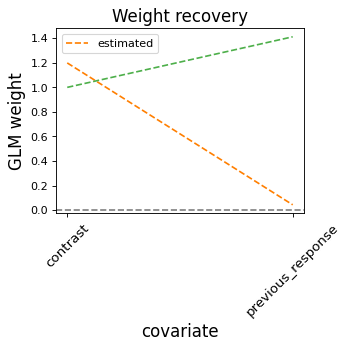

In [34]:
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
cols = ['#ff7f00', '#4daf4a', '#377eb8',  '#8B0000', '#000000']
for k in range(num_states):
    if k ==0:
        
        plt.plot(range(input_dim), -recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = "estimated", linestyle = '--')
    else:
        plt.plot(range(input_dim), -recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = '', linestyle = '--')
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1], ['contrast', 'previous_response'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("Weight recovery", fontsize=15)

In [ ]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("recovered", fontsize = 15)
plt.subplots_adjust(0, 0, 1, 1)

## Posterior State Probabilities

Let's now plot $p(z_{t} = k|\mathbf{y}, \{u_{t}\}_{t=1}^{T})$, the posterior state probabilities, which give the probability of the animal being in state k at trial t.

In [65]:
# run average model
prior_sigma = 10

glmhmm = ssm.HMM(num_states, obs_dim, input_dim, 
                        observations="input_driven_obs", 
                        observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma), 
                        transitions="sticky", 
                        transition_kwargs=dict(alpha=transition_alpha, kappa=0))
        
glmhmm.init_state_distn.params = np.log([0.5, 0.5])
glmhmm.observations.params = -param_init_ext_int[0:4].reshape(2,1,2)
glmhmm.transitions.params = (param_init_ext_int[4:8].reshape(2,2),)

_ = glmhmm.fit(choices, inputs=inpts, method="em", num_iters=N_iters, initialize = False, tolerance=10**-4, verbose = False)
print(-glmhmm.observations.params)
index_ext = np.argmax(np.concatenate(-glmhmm.observations.params)[:,0])
index_int = np.argmin(np.concatenate(-glmhmm.observations.params)[:,0])

[[[1.19823064 0.04152385]]

 [[0.99988245 1.4113977 ]]]


In [66]:
# Get expected states:
posterior_probs = [glmhmm.expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip(choices, inpts)]

Text(0, 0.5, 'p(state)')

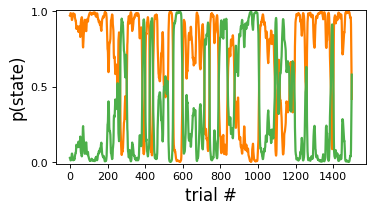

In [67]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
sess_id = 6 #session id; can choose any index between 0 and num_sess-1
for k in range(num_states):
    plt.plot(posterior_probs[sess_id][1:1500, k], label="State " + str(k + 1), lw=2,
             color=cols[k])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlabel("trial #", fontsize = 15)
plt.ylabel("p(state)", fontsize = 15)

With these posterior state probabilities, we can assign trials to states and then plot the fractional occupancy of each state:

In [68]:
# concatenate posterior probabilities across sessions
posterior_probs_concat = np.concatenate(posterior_probs)
# get state with maximum posterior probability at particular trial:
state_max_posterior = np.argmax(posterior_probs_concat, axis = 1)
# now obtain state fractional occupancies:
_, state_occupancies = np.unique(state_max_posterior, return_counts=True)
state_occupancies = state_occupancies/np.sum(state_occupancies)

Text(0, 0.5, 'frac. occupancy')

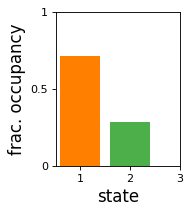

In [69]:
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
for z, occ in enumerate(state_occupancies):
    plt.bar(z, occ, width = 0.8, color = cols[z])
plt.ylim((0, 1))
plt.xticks([0, 1, 2], ['1', '2', '3'], fontsize = 10)
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10)
plt.xlabel('state', fontsize = 15)
plt.ylabel('frac. occupancy', fontsize=15)

In [70]:
df = df.assign(Gl_Prob_State_ext = posterior_probs_concat[:,index_ext])
df = df.assign(Gl_Prob_State_int = posterior_probs_concat[:,index_int])

if save_data:
    df.to_csv(root_dir + 'HMM/Full_HMM.csv', index = False)